In [ ]:
import os, glob

DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
print("Total images found:", len(files))
print("Example file:", files[0])

In [ ]:
# =========================
# 0️⃣ Imports
import os, cv2, numpy as np
from glob import glob
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# =========================
# 1️⃣ Load and preprocess dataset (fast)
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
files = glob(os.path.join(DATA_DIR, "*.jpg"))

N = min(11000, len(files))  # Use max 11000 images
files = files[:N]

def parse_utk_filename(path):
    fname = os.path.basename(path)
    age, gender, *_ = fname.split("_", 3)
    return int(age), int(gender)

def age_group(age):
    if age < 20: return 0
    if age <= 30: return 1
    return 2

images, genders, age_groups_list = [], [], []

# Vectorized-ish loading
for f in files:
    age, gender = parse_utk_filename(f)
    img = cv2.imread(f)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    images.append(img)
    genders.append(gender)
    age_groups_list.append(age_group(age))

# Convert to numpy arrays and normalize
X = np.array(images, dtype="float32") / 255.0
y_gender = np.array(genders).reshape(-1,1)
y_age = to_categorical(np.array(age_groups_list), 3)

# Shuffle
X, y_gender, y_age = shuffle(X, y_gender, y_age, random_state=42)

# =========================
# 2️⃣ Save preprocessed arrays for future runs
np.save("/kaggle/working/X.npy", X)
np.save("/kaggle/working/y_gender.npy", y_gender)
np.save("/kaggle/working/y_age.npy", y_age)

print("Data loaded and saved successfully!")
print("X:", X.shape, "y_gender:", y_gender.shape, "y_age:", y_age.shape)

# =========================
# 3️⃣ Optional: reload quickly next time
# X = np.load("/kaggle/working/X.npy")
# y_gender = np.load("/kaggle/working/y_gender.npy")
# y_age = np.load("/kaggle/working/y_age.npy")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

X_train, X_val, y_train_gender, y_val_gender, y_train_age, y_val_age = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42, stratify=y_gender
)

# =========================
# 3️⃣ Build custom CNN model
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

# Two output heads
gender_out = Dense(1, activation='sigmoid', name='gender_out')(x)
age_out = Dense(3, activation='softmax', name='age_out')(x)

model = Model(inputs=inputs, outputs=[gender_out, age_out])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'categorical_crossentropy'},
    metrics={'gender_out': 'accuracy', 'age_out': 'accuracy'}
)

model.summary()

In [ ]:
np.save("/kaggle/working/X.npy", X)
np.save("/kaggle/working/y_gender.npy", y_gender)
np.save("/kaggle/working/y_age.npy", y_age)

# Later just load
# X = np.load("/kaggle/working/X.npy")
# y_gender = np.load("/kaggle/working/y_gender.npy")
# y_age = np.load("/kaggle/working/y_age.npy")

In [ ]:
train_labels = {"gender_out": y_train_gender, "age_out": y_train_age}
val_labels   = {"gender_out": y_val_gender, "age_out": y_val_age}

train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, val_labels))

# Data augmentation
def augment(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, labels

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# =========================
# 5️⃣ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=2, min_lr=1e-6)

# =========================
# 6️⃣ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, lr]
)

# =========================
# 7️⃣ Save the model
model.save("/kaggle/working/age_gender_model.h5")
print("Model saved successfully!")

In [ ]:
model.save("age_gender_model.h5")

In [26]:
# Evaluate the model
total_loss, gender_loss, age_loss, gender_acc, age_acc = model.evaluate(X_val, [y_val_gender, y_val_age])

print("Evaluation results on validation set:")
print(f"Total loss: {total_loss:.4f}")
print(f"Gender loss: {gender_loss:.4f}, Gender accuracy: {gender_acc:.4f}")
print(f"Age loss: {age_loss:.4f}, Age accuracy: {age_acc:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - age_out_accuracy: 0.7795 - age_out_loss: 0.4980 - gender_out_accuracy: 0.9103 - gender_out_loss: 0.2206 - loss: 0.8518
Evaluation results on validation set:
Total loss: 0.8572
Gender loss: 0.2128, Gender accuracy: 0.7718
Age loss: 0.5115, Age accuracy: 0.9082


In [ ]:
from glob import glob
import os

DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
selected_files = glob(os.path.join(DATA_DIR, "*.jpg"))[:100]

In [ ]:
# Pre-labeled hair labels for first 20 images
hair_labels = {
    '26_0_2_20170104023102422.jpg.chip.jpg': 1,
    '22_1_1_20170112233644761.jpg.chip.jpg': 0,
    '21_1_3_20170105003215901.jpg.chip.jpg': 1,
    '28_0_0_20170117180555824.jpg.chip.jpg': 0,
    '17_1_4_20170103222931966.jpg.chip.jpg': 1,
    '44_0_3_20170119201022260.jpg.chip.jpg': 0,
    '35_0_2_20170116182734834.jpg.chip.jpg': 0,
    '76_0_0_20170104213515132.jpg.chip.jpg': 0,
    '36_1_0_20170116165722892.jpg.chip.jpg': 0,
    '34_0_3_20170119200815948.jpg.chip.jpg': 0,
    '18_1_0_20170104022856102.jpg.chip.jpg': 1,
    '40_1_1_20170113011948248.jpg.chip.jpg': 0,
    '45_0_0_20170117180013541.jpg.chip.jpg': 0,
    '26_1_1_20170117153641469.jpg.chip.jpg': 0,
    '70_1_0_20170120222024102.jpg.chip.jpg': 1,
    '26_1_0_20170117174144110.jpg.chip.jpg': 1,
    '67_0_2_20170112224629884.jpg.chip.jpg': 0,
    '12_1_0_20170109203700059.jpg.chip.jpg': 1,
    '24_1_2_20170116173442433.jpg.chip.jpg': 1,
    '54_0_3_20170117155453576.jpg.chip.jpg': 0
}

In [ ]:
# ==============================
# 1️⃣ Preprocess labeled images
# ==============================
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import os

X_hair_train = []
y_hair_train = []

for f in hair_labels.keys():
    img_path = os.path.join(DATA_DIR, f)
    img = cv2.imread(img_path)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.astype("float32") / 255.0
    X_hair_train.append(img)
    
    y_hair_train.append(hair_labels[f])

X_hair_train = np.array(X_hair_train)
y_hair_train = np.array(y_hair_train)

print("X_hair_train shape:", X_hair_train.shape)
print("y_hair_train shape:", y_hair_train.shape)


# ==============================
# 2️⃣ Define hair-length model
# ==============================
hair_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(hair_base.output)
x = Dropout(0.5)(x)
hair_out = Dense(1, activation='sigmoid', name='hair_out')(x)
hair_model = Model(inputs=hair_base.input, outputs=hair_out)
hair_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ==============================
# 3️⃣ Train small hair-length model
# ==============================
hair_model.fit(
    X_hair_train, y_hair_train,
    validation_split=0.2,
    epochs=10,
    batch_size=4  # small batch because dataset is tiny
)

# ==============================
# 4️⃣ Save the trained model
# ==============================
hair_model.save('hair_model_20.h5')
print("Hair-length model trained and saved!")

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ==============================
# 1️⃣ Load pre-trained small hair model
# ==============================
hair_model = load_model('hair_model_20.h5')

# ==============================
# 2️⃣ Select a smaller subset of UTKFace images (unlabeled)
# ==============================
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
all_files = glob(os.path.join(DATA_DIR, "*.jpg"))
labeled_files = list(hair_labels.keys())

MAX_UNLABELED = 500  # smaller subset to reduce time
unlabeled_files = [f for f in all_files if os.path.basename(f) not in labeled_files][:MAX_UNLABELED]
print("Number of unlabeled images used:", len(unlabeled_files))

# ==============================
# 3️⃣ Preprocess unlabeled images
# ==============================
X_unlabeled = []
file_names = []

for f in unlabeled_files:
    img = cv2.imread(f)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.astype("float32") / 255.0
    X_unlabeled.append(img)
    file_names.append(os.path.basename(f))

X_unlabeled = np.array(X_unlabeled)
print("Preprocessed unlabeled images shape:", X_unlabeled.shape)

# ==============================
# 4️⃣ Predict hair length on unlabeled images
# ==============================
preds = hair_model.predict(X_unlabeled, verbose=1)
pred_labels = (preds > 0.5).astype(int).flatten()  # 0=short, 1=long

# Optional: check a few predictions
for i in range(5):
    print(file_names[i], "->", pred_labels[i])

# ==============================
# 5️⃣ Combine with manually labeled images
# ==============================
X_labeled = []
y_labeled = []

for f in hair_labels.keys():
    img_path = os.path.join(DATA_DIR, f)
    img = cv2.imread(img_path)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.astype("float32") / 255.0
    X_labeled.append(img)
    y_labeled.append(hair_labels[f])

X_labeled = np.array(X_labeled)
y_labeled = np.array(y_labeled)

# Combine labeled + pseudo-labeled
X_combined = np.concatenate([X_labeled, X_unlabeled])
y_combined = np.concatenate([y_labeled, pred_labels])

print("Combined dataset shape:", X_combined.shape, y_combined.shape)

# ==============================
# 6️⃣ Define new hair-length model
# ==============================
hair_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(hair_base.output)
x = Dropout(0.5)(x)
hair_out = Dense(1, activation='sigmoid', name='hair_out')(x)
hair_model_full = Model(inputs=hair_base.input, outputs=hair_out)
hair_model_full.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ==============================
# 7️⃣ Train on combined dataset
# ==============================
history = hair_model_full.fit(
    X_combined, y_combined,
    validation_split=0.2,
    epochs=5,       # fewer epochs to save time
    batch_size=16,  # smaller batch for speed
    shuffle=True,
    verbose=2
)

# ==============================
# 8️⃣ Save final model
# ==============================
hair_model_full.save("hair_model_full.h5")
print("Final hair-length model trained and saved!")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Hair-Length Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Hair-Length Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
model.save("age_gender_model.h5")
print("Model saved successfully!")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("age_gender_model.h5")
print("Model loaded successfully!")

In [ ]:
total_loss, gender_loss, age_loss, gender_acc, age_acc = model.evaluate(X_val, [y_val_gender, y_val_age])
print("Total loss:", total_loss)
print("Gender loss:", gender_loss, "Gender acc:", gender_acc)
print("Age loss:", age_loss, "Age acc:", age_acc)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("age_gender_model.h5")

In [22]:
# Pick the image
img = X[500]
true_gender = y_gender[0][0]    # actual gender label (0=female, 1=male)
true_age_group = np.argmax(y_age[0])  # actual age group label (0=<20, 1=21-30, 2=>30)

# Expand dims for model input
img_input = np.expand_dims(img, axis=0)

# Predict
pred_gender, pred_age = model.predict(img_input)

# Convert predictions to class labels
pred_gender_class = int(pred_gender[0][0] > 0.5)  # threshold sigmoid
pred_age_class = int(np.argmax(pred_age[0]))      # softmax argmax

# Print raw predictions and actual labels
print("Raw predictions:")
print("Gender output (sigmoid):", pred_gender)
print("Age output (softmax):", pred_age)

print("\nPredicted labels:")
print("Gender:", pred_gender_class, "| Age group:", pred_age_class)

print("\nActual labels:")
print("Gender:", true_gender, "| Age group:", true_age_group)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Raw predictions:
Gender output (sigmoid): [[0.40045094]]
Age output (softmax): [[9.9842417e-01 3.1279182e-04 1.2630101e-03]]

Predicted labels:
Gender: 0 | Age group: 0

Actual labels:
Gender: 1 | Age group: 2


In [23]:
import numpy as np
print(np.bincount(np.argmax(y_age, axis=1)))

[2121 3770 5109]


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import cv2

# Load your trained models (do this once)
age_gender_model = load_model("age_gender_model.h5")
hair_model = load_model("hair_model_full.h5")

def predict_gender_with_hair(img):
    """
    img: RGB image (224x224x3) as numpy array
    Returns: predicted_gender (0=female, 1=male), predicted_age_group (0=<20,1=20-30,2=>30)
    """

    # Preprocess input
    img_input = cv2.resize(img, (224,224))
    img_input = img_input.astype("float32") / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # 1️⃣ Predict age and gender
    pred_gender, pred_age = age_gender_model.predict(img_input)
    pred_gender_class = int(pred_gender[0][0] > 0.5)
    pred_age_class = int(np.argmax(pred_age[0]))

    # 2️⃣ Predict hair length
    hair_pred = hair_model.predict(img_input)
    hair_length = "long" if hair_pred[0][0] > 0.5 else "short"

    # 3️⃣ Apply special logic for age 20-30
    if pred_age_class == 1:  # 20-30 age group
        if hair_length == "long":
            pred_gender_class = 1  # female -> 1 (if your mapping uses 1=female)
        elif hair_length == "short":
            pred_gender_class = 0  # male -> 0

    return pred_gender_class, pred_age_class, hair_length

# =========================
# Example usage
# img = X[0]  # pick an image from your dataset
# gender, age_group, hair = predict_gender_with_hair(img)
# print("Predicted gender:", gender, "Age group:", age_group, "Hair:", hair)

In [21]:
# Pick 5 random images from your validation set
for i in range(5):
    img = X_val[i]
    true_gender = y_val_gender[i][0]
    true_age_group = np.argmax(y_val_age[i])

    pred_gender, pred_age_group, hair = predict_gender_with_hair(img)

    print(f"Image {i}:")
    print(f"  True gender: {true_gender}, True age group: {true_age_group}")
    print(f"  Predicted gender: {pred_gender}, Predicted age group: {pred_age_group}, Hair: {hair}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 0:
  True gender: 1, True age group: 1
  Predicted gender: 0, Predicted age group: 1, Hair: short

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 1:
  True gender: 0, True age group: 0
  Predicted gender: 0, Predicted age group: 1, Hair: short

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 2:
  True gender: 0, True age group: 2
  Predicted gender: 0, Predicted age group: 1, Hair: short

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 3:
  True gender: 1, True age group: 2
  Predicted gender: 0, Predicted age group: 1, Hair: short

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 4:
  True gender: 1, True age group: 2
  Predicted gender: 0, Predicted age group: 1, Hair: short



In [27]:
from IPython.display import FileLink, display
import os

# List of model files you want to download
model_files = [
    "age_gender_model.h5",
    "hair_model_20.h5",
    "hair_model_full.h5"
]

# Check if each file exists and display a clickable link
for model_file in model_files:
    if os.path.exists(model_file):
        display(FileLink(model_file))
    else:
        print(f"File not found: {model_file}")

/kaggle/working/age_gender_model.h5

/kaggle/working/hair_model_20.h5

/kaggle/working/hair_model_full.h5

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


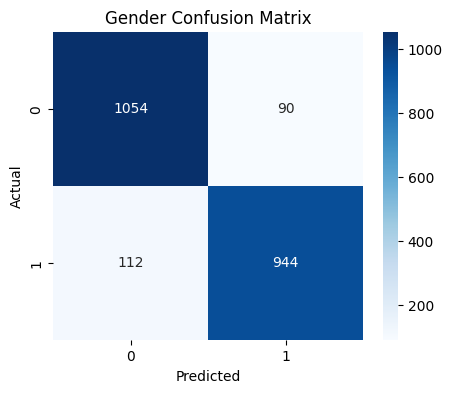

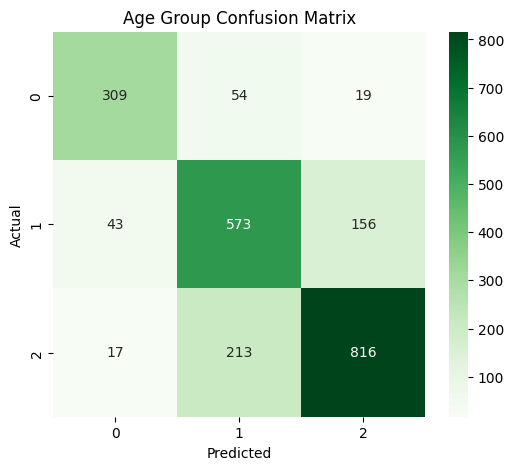

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Predict on validation set
pred_gender_val, pred_age_val = model.predict(X_val)

# Convert to class labels
pred_gender_classes = (pred_gender_val > 0.5).astype(int).flatten()
true_gender_classes = y_val_gender.flatten()

pred_age_classes = np.argmax(pred_age_val, axis=1)
true_age_classes = np.argmax(y_val_age, axis=1)
# Gender
cm_gender = confusion_matrix(true_gender_classes, pred_gender_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues')
plt.title("Gender Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Age
cm_age = confusion_matrix(true_age_classes, pred_age_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm_age, annot=True, fmt='d', cmap='Greens')
plt.title("Age Group Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [29]:
# Gender
print("Gender Classification Report:")
print(classification_report(true_gender_classes, pred_gender_classes, target_names=['Female','Male']))

# Age
print("Age Group Classification Report:")
print(classification_report(true_age_classes, pred_age_classes, target_names=['<20','20-30','>30']))


Gender Classification Report:
              precision    recall  f1-score   support

      Female       0.90      0.92      0.91      1144
        Male       0.91      0.89      0.90      1056

    accuracy                           0.91      2200
   macro avg       0.91      0.91      0.91      2200
weighted avg       0.91      0.91      0.91      2200

Age Group Classification Report:
              precision    recall  f1-score   support

         <20       0.84      0.81      0.82       382
       20-30       0.68      0.74      0.71       772
         >30       0.82      0.78      0.80      1046

    accuracy                           0.77      2200
   macro avg       0.78      0.78      0.78      2200
weighted avg       0.78      0.77      0.77      2200

